Import Library

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

Load The Data

In [48]:
df = pd.read_csv('movie-review.csv')

Data Preparation

In [49]:
df.head()

,Username,Review,Rating,Thumbsup,Date
0,AussieCritics,"Joker released on the 3rd of October, 2019 and...",8,0,"Apr 2, 2020"
1,GEEKAM,"This review contains spoilers, click expand to...",10,0,"Apr 2, 2020"
2,AlohaSnackbar,An amazing film from start to finish. A must w...,10,0,"Apr 2, 2020"
3,ronnich,Iconic movie. Psychological drama where the be...,10,0,"Apr 3, 2020"
4,CoreGamer1408,Maybe the decent into darkness themes are just...,7,0,"Apr 4, 2020"


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2786 entries, 0 to 2785
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Username  2786 non-null   object
 1   Review    2785 non-null   object
 2   Rating    2786 non-null   int64 
 3   Thumbsup  2786 non-null   int64 
 4   Date      2786 non-null   object
dtypes: int64(2), object(3)
memory usage: 109.0+ KB


In [51]:
check_null = pd.isnull(df['Review'])
df[check_null]

,Username,Review,Rating,Thumbsup,Date
594,ZakiMaqsood,NaN,10,0,"Nov 14, 2019"


In [52]:
# Remove null value
new_df = df.drop(df.index[594])

In [53]:
new_df.isna().sum()

Username    0
Review      0
Rating      0
Thumbsup    0
Date        0
dtype: int64

In [54]:
# rating transformation

def transform_rating(rating):
    if rating == 10 or rating == 9 or rating == 8 or rating == 7:
        return "Good"
    if rating == 6 or rating == 5 or rating == 4:
        return "Neutral"
    if rating == 3 or rating == 2 or rating == 1 or rating == 0:
        return "Bad"

In [55]:
# Apply rating transformation
new_df['Sentiment'] = new_df['Rating'].apply(transform_rating)

In [56]:
# Crate length of review
new_df['Length'] = new_df['Review'].str.len()

In [57]:
new_df.head()

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
0,AussieCritics,"Joker released on the 3rd of October, 2019 and...",8,0,"Apr 2, 2020",Good,2209
1,GEEKAM,"This review contains spoilers, click expand to...",10,0,"Apr 2, 2020",Good,330
2,AlohaSnackbar,An amazing film from start to finish. A must w...,10,0,"Apr 2, 2020",Good,89
3,ronnich,Iconic movie. Psychological drama where the be...,10,0,"Apr 3, 2020",Good,85
4,CoreGamer1408,Maybe the decent into darkness themes are just...,7,0,"Apr 4, 2020",Good,656


Visualization and Exploratory Data Analysis (EDA)

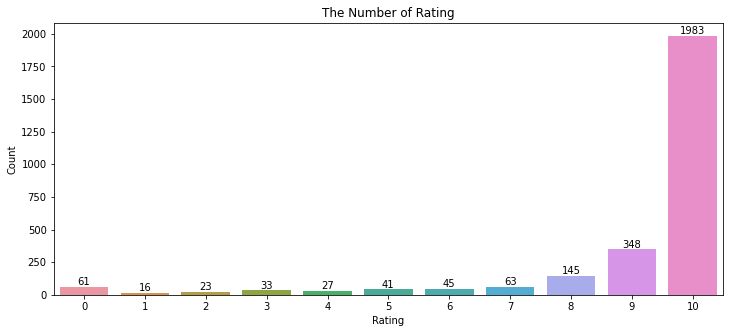

In [58]:
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.countplot(new_df['Rating'])

ax.set(ylabel='Count')
ax.set_title('The Number of Rating')
ax.bar_label(ax.containers[0])
plt.show()

#fig.savefig('bar_chart.png')

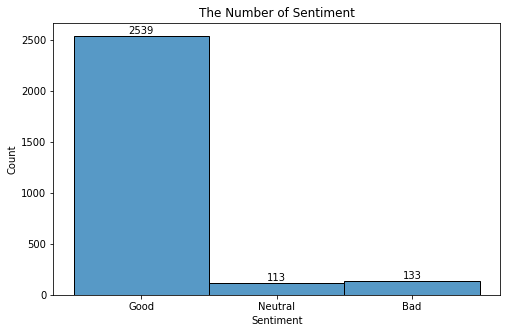

In [59]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.histplot(new_df['Sentiment'])

ax.set(ylabel='Count')
ax.set_title('The Number of Sentiment')
ax.bar_label(ax.containers[0])
plt.show()

#fig.savefig('sentiment.png')

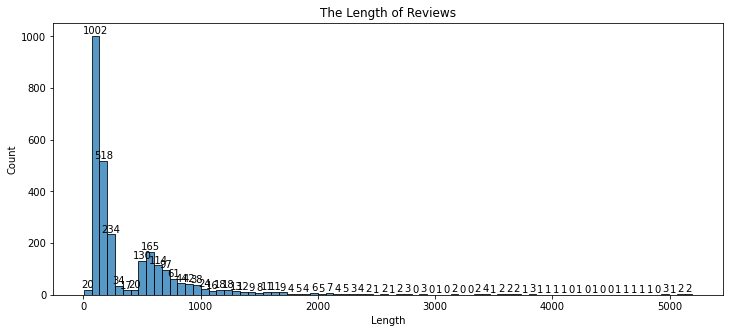

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.histplot(new_df['Length'])

ax.set(ylabel='Count')
ax.set_title('The Length of Reviews')
ax.bar_label(ax.containers[0])
plt.show()

#fig.savefig('length_reviews.png')

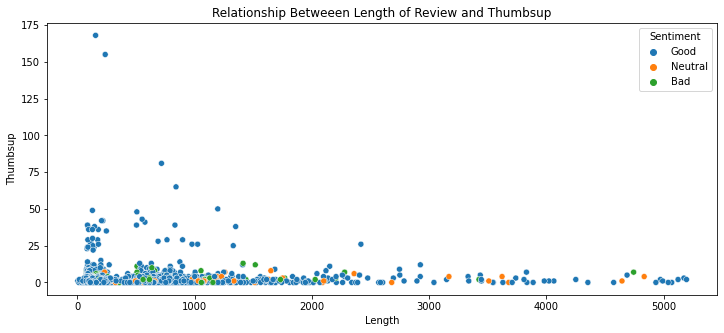

In [61]:
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.scatterplot(x=new_df['Length'], 
                     y=new_df['Thumbsup'],
                     hue=new_df['Sentiment']
                    )

ax.set_title('Relationship Betweeen Length of Review and Thumbsup')
plt.show()

#fig.savefig('relation_length_thumbsup.png')

Text Processing

1. Change all words to lowercase
2. Remove punctuations
3. Remove whitespace
4. Stopword removal
5. Lemmatization

In [62]:
new_df.head(20)

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
0,AussieCritics,"Joker released on the 3rd of October, 2019 and...",8,0,"Apr 2, 2020",Good,2209
1,GEEKAM,"This review contains spoilers, click expand to...",10,0,"Apr 2, 2020",Good,330
2,AlohaSnackbar,An amazing film from start to finish. A must w...,10,0,"Apr 2, 2020",Good,89
3,ronnich,Iconic movie. Psychological drama where the be...,10,0,"Apr 3, 2020",Good,85
4,CoreGamer1408,Maybe the decent into darkness themes are just...,7,0,"Apr 4, 2020",Good,656
5,Louw_Burger,Joker gives its infamous central character a c...,8,0,"Apr 5, 2020",Good,179
6,Tony_Soruyo,"Phoenix is the movie, a masterpiece just becau...",10,0,"Apr 6, 2022",Good,81
7,RafaCa66,"In my opinion, one of the BEST movies of 2019,...",10,1,"Apr 7, 2021",Good,592
8,Frankdnb,"Amazing movie, beautifully acted and riveting....",10,0,"Apr 8, 2020",Good,116
9,BuboTHEMIGHTY,"Amazing, completely and utterly brilliant, but...",8,0,"Apr 8, 2021",Good,507


In [63]:
lowercase = lambda x: ' '.join(x.lower() for x in x.split())
new_df.iloc[:, 1] = new_df.iloc[:, 1].apply(lowercase)
new_df.head(20)

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
0,AussieCritics,"joker released on the 3rd of october, 2019 and...",8,0,"Apr 2, 2020",Good,2209
1,GEEKAM,"this review contains spoilers, click expand to...",10,0,"Apr 2, 2020",Good,330
2,AlohaSnackbar,an amazing film from start to finish. a must w...,10,0,"Apr 2, 2020",Good,89
3,ronnich,iconic movie. psychological drama where the be...,10,0,"Apr 3, 2020",Good,85
4,CoreGamer1408,maybe the decent into darkness themes are just...,7,0,"Apr 4, 2020",Good,656
5,Louw_Burger,joker gives its infamous central character a c...,8,0,"Apr 5, 2020",Good,179
6,Tony_Soruyo,"phoenix is the movie, a masterpiece just becau...",10,0,"Apr 6, 2022",Good,81
7,RafaCa66,"in my opinion, one of the best movies of 2019,...",10,1,"Apr 7, 2021",Good,592
8,Frankdnb,"amazing movie, beautifully acted and riveting....",10,0,"Apr 8, 2020",Good,116
9,BuboTHEMIGHTY,"amazing, completely and utterly brilliant, but...",8,0,"Apr 8, 2021",Good,507


In [64]:
remove_punctuations = lambda word: re.sub('[^\w\d]', ' ', word)
new_df.iloc[:, 1] = new_df.iloc[:, 1].apply(remove_punctuations)
new_df.head(20)

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
0,AussieCritics,joker released on the 3rd of october 2019 and...,8,0,"Apr 2, 2020",Good,2209
1,GEEKAM,this review contains spoilers click expand to...,10,0,"Apr 2, 2020",Good,330
2,AlohaSnackbar,an amazing film from start to finish a must w...,10,0,"Apr 2, 2020",Good,89
3,ronnich,iconic movie psychological drama where the be...,10,0,"Apr 3, 2020",Good,85
4,CoreGamer1408,maybe the decent into darkness themes are just...,7,0,"Apr 4, 2020",Good,656
5,Louw_Burger,joker gives its infamous central character a c...,8,0,"Apr 5, 2020",Good,179
6,Tony_Soruyo,phoenix is the movie a masterpiece just becau...,10,0,"Apr 6, 2022",Good,81
7,RafaCa66,in my opinion one of the best movies of 2019 ...,10,1,"Apr 7, 2021",Good,592
8,Frankdnb,amazing movie beautifully acted and riveting ...,10,0,"Apr 8, 2020",Good,116
9,BuboTHEMIGHTY,amazing completely and utterly brilliant but...,8,0,"Apr 8, 2021",Good,507


In [65]:
print(new_df.iloc[73])

Username                                       jokerisgreatest
Review       joker is greatest movie all time         da cr...
Rating                                                      10
Thumbsup                                                     0
Date                                              Dec  8, 2019
Sentiment                                                 Good
Length                                                      85
Name: 73, dtype: object


In [66]:
remove_whitespace = lambda x: ' '.join((''.join(x.splitlines())).split())
new_df.iloc[:, 1] = new_df.iloc[:, 1].apply(remove_whitespace)
new_df.head(20)

# https://stackoverflow.com/questions/2077897/substitute-multiple-whitespace-with-single-whitespace-in-python

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
0,AussieCritics,joker released on the 3rd of october 2019 and ...,8,0,"Apr 2, 2020",Good,2209
1,GEEKAM,this review contains spoilers click expand to ...,10,0,"Apr 2, 2020",Good,330
2,AlohaSnackbar,an amazing film from start to finish a must wa...,10,0,"Apr 2, 2020",Good,89
3,ronnich,iconic movie psychological drama where the bes...,10,0,"Apr 3, 2020",Good,85
4,CoreGamer1408,maybe the decent into darkness themes are just...,7,0,"Apr 4, 2020",Good,656
5,Louw_Burger,joker gives its infamous central character a c...,8,0,"Apr 5, 2020",Good,179
6,Tony_Soruyo,phoenix is the movie a masterpiece just becaus...,10,0,"Apr 6, 2022",Good,81
7,RafaCa66,in my opinion one of the best movies of 2019 e...,10,1,"Apr 7, 2021",Good,592
8,Frankdnb,amazing movie beautifully acted and riveting n...,10,0,"Apr 8, 2020",Good,116
9,BuboTHEMIGHTY,amazing completely and utterly brilliant but i...,8,0,"Apr 8, 2021",Good,507


In [67]:
print(new_df.iloc[74])

Username                                               noob328
Review       this film is decent and has the best joaquin p...
Rating                                                      10
Thumbsup                                                     2
Date                                              Dec  8, 2020
Sentiment                                                 Good
Length                                                      92
Name: 74, dtype: object


In [68]:
stop_words = stopwords.words('english')
temp = lambda word: ' '.join(word for word in word.split() if word not in stop_words)
new_df.iloc[:, 1] = new_df.iloc[:, 1].apply(temp)
new_df.head(20)

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
0,AussieCritics,joker released 3rd october 2019 grossed 4 mill...,8,0,"Apr 2, 2020",Good,2209
1,GEEKAM,review contains spoilers click expand view exc...,10,0,"Apr 2, 2020",Good,330
2,AlohaSnackbar,amazing film start finish must watch topical d...,10,0,"Apr 2, 2020",Good,89
3,ronnich,iconic movie psychological drama best actor sh...,10,0,"Apr 3, 2020",Good,85
4,CoreGamer1408,maybe decent darkness themes thing comedy happ...,7,0,"Apr 4, 2020",Good,656
5,Louw_Burger,joker gives infamous central character chillin...,8,0,"Apr 5, 2020",Good,179
6,Tony_Soruyo,phoenix movie masterpiece performance joker,10,0,"Apr 6, 2022",Good,81
7,RafaCa66,opinion one best movies 2019 everything great ...,10,1,"Apr 7, 2021",Good,592
8,Frankdnb,amazing movie beautifully acted riveting sure ...,10,0,"Apr 8, 2020",Good,116
9,BuboTHEMIGHTY,amazing completely utterly brilliant uninteres...,8,0,"Apr 8, 2021",Good,507


In [69]:
lemmatization = WordNetLemmatizer()
temp = lambda word: " ".join(lemmatization.lemmatize(word) for word in word.split())
new_df.iloc[:, 1] = new_df.iloc[:, 1].apply(temp)
new_df.head(20)

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
0,AussieCritics,joker released 3rd october 2019 grossed 4 mill...,8,0,"Apr 2, 2020",Good,2209
1,GEEKAM,review contains spoiler click expand view exce...,10,0,"Apr 2, 2020",Good,330
2,AlohaSnackbar,amazing film start finish must watch topical d...,10,0,"Apr 2, 2020",Good,89
3,ronnich,iconic movie psychological drama best actor sh...,10,0,"Apr 3, 2020",Good,85
4,CoreGamer1408,maybe decent darkness theme thing comedy happy...,7,0,"Apr 4, 2020",Good,656
5,Louw_Burger,joker give infamous central character chilling...,8,0,"Apr 5, 2020",Good,179
6,Tony_Soruyo,phoenix movie masterpiece performance joker,10,0,"Apr 6, 2022",Good,81
7,RafaCa66,opinion one best movie 2019 everything great n...,10,1,"Apr 7, 2021",Good,592
8,Frankdnb,amazing movie beautifully acted riveting sure ...,10,0,"Apr 8, 2020",Good,116
9,BuboTHEMIGHTY,amazing completely utterly brilliant uninteres...,8,0,"Apr 8, 2021",Good,507


In [70]:
positive_review = new_df[new_df['Sentiment'] == 'Good']
positive_review.head(5)

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
0,AussieCritics,joker released 3rd october 2019 grossed 4 mill...,8,0,"Apr 2, 2020",Good,2209
1,GEEKAM,review contains spoiler click expand view exce...,10,0,"Apr 2, 2020",Good,330
2,AlohaSnackbar,amazing film start finish must watch topical d...,10,0,"Apr 2, 2020",Good,89
3,ronnich,iconic movie psychological drama best actor sh...,10,0,"Apr 3, 2020",Good,85
4,CoreGamer1408,maybe decent darkness theme thing comedy happy...,7,0,"Apr 4, 2020",Good,656


In [71]:
neutral_review = new_df[new_df['Sentiment'] == 'Neutral']
neutral_review.head()

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
11,Jaredc324,marvel boyband fan praise movie victimized per...,6,0,"Apr 9, 2022",Neutral,680
14,Willywonka180,joker great point fails overall depiction ment...,6,1,"Apr 10, 2021",Neutral,779
22,ferrisb,first half exciting really much happened fine ...,4,0,"Apr 15, 2022",Neutral,141
71,rideawave,think people like movie love joker character m...,6,3,"Dec 7, 2020",Neutral,506
104,UncleWillard,finally saw joker really surprise expected app...,6,6,"Dec 18, 2019",Neutral,2361


In [72]:
bad_review = new_df[new_df['Sentiment'] == 'Bad']
bad_review.head(5)

,Username,Review,Rating,Thumbsup,Date,Sentiment,Length
13,Hawk321,good movie yet perhaps movie become good watch...,2,1,"Apr 10, 2020",Bad,110
34,KenR,easily pleased people become major movie simpl...,2,3,"Aug 6, 2020",Bad,1769
39,Danielpve,dumb movie dumb people nothing thing actually ...,2,4,"Aug 20, 2020",Bad,155
51,sendani,donot love nolan movie see joker movie nolan f...,0,1,"Dec 3, 2019",Bad,149
61,MarcoV246,good wish better script weak dialogue cliche,2,1,"Dec 6, 2019",Bad,79


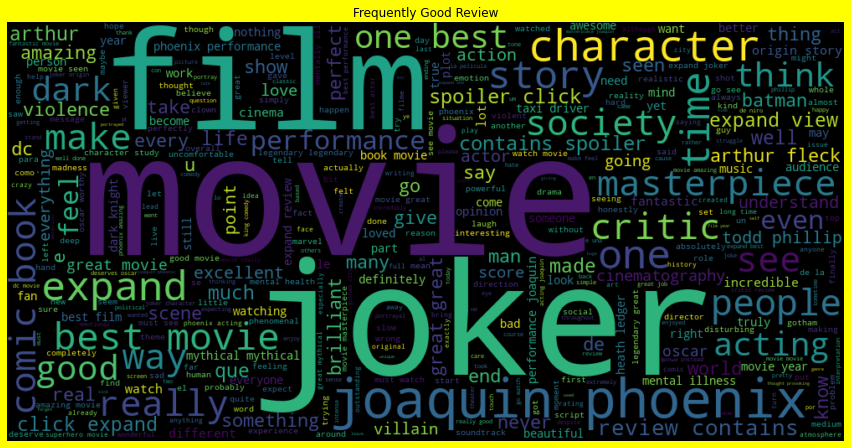

In [73]:
viewing_positive = ' '.join([word for word in positive_review['Review']])

fig, ax = plt.subplots(figsize=(15, 15))
wordcloud = WordCloud(max_words=400, 
                      width=1000, 
                      height=500).generate(viewing_positive)
ax.imshow(wordcloud, 
          interpolation='bilinear')
ax.axis('off')
ax.set_title("Frequently Good Review")
fig.set_facecolor('yellow')
fig.show()

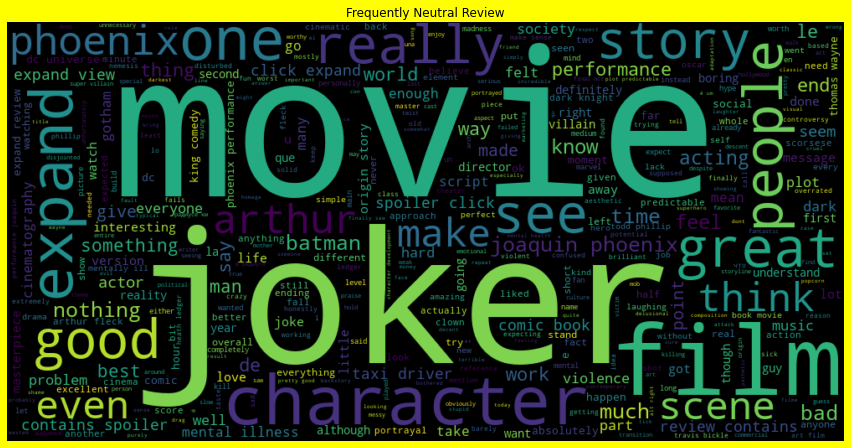

In [74]:
viewing_neutral = ' '.join([word for word in neutral_review['Review']])

fig, ax = plt.subplots(figsize=(15, 15))
wordcloud = WordCloud(max_words=400,
                      width=1000,
                      height=500).generate(viewing_neutral)
ax.imshow(wordcloud,
          interpolation='bilinear')
ax.axis('off')
fig.set_facecolor('yellow')
ax.set_title("Frequently Neutral Review")
fig.show()

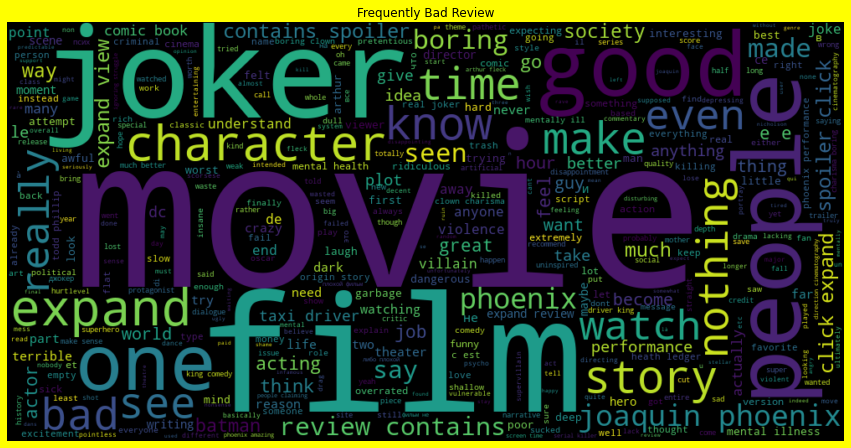

In [75]:
viewing_bad = ' '.join([word for word in bad_review['Review']])

fig, ax = plt.subplots(figsize=(15, 15))
wordcloud = WordCloud(max_words=400, 
                      width=1000, 
                      height=500).generate(viewing_bad)
ax.imshow(wordcloud,
          interpolation='bilinear')
ax.axis('off')
ax.set_title("Frequently Bad Review")
fig.set_facecolor('yellow')
fig.show()

Model Building

In [76]:
cv = CountVectorizer(ngram_range=(1, 2)).fit(new_df['Review'])
get_fn = cv.get_feature_names()

print('Total features: ', len(get_fn))
print('First 30 features: ', get_fn[:30])

Total features:  81373
First 30 features:  ['0001', '0001 do', '10', '10 10', '10 10acting', '10 10grade', '10 10joaquin', '10 10oh', '10 10overall', '10 10score', '10 10story', '10 10this', '10 10violence', '10 10атмосфера', '10 90', '10 aave', '10 absolutely', '10 age', '10 almost', '10 also', '10 amazing', '10 aunque', '10 awesome', '10 best', '10 buck', '10 cinematography', '10 combatthe', '10 come', '10 considering', '10 could']


In [77]:
x = new_df['Review']
y = new_df['Sentiment']

In [78]:
x = cv.transform(x)

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=20)

print('x_train size: ', x_train.shape)
print('x_test size: ', x_test.shape)
print('y_train size: ', y_train.shape)
print('y_test size: ', y_test.shape)

x_train size:  (1949, 81373)
x_test size:  (836, 81373)
y_train size:  (1949,)
y_test size:  (836,)


    SVM (Support Vector Machine)

In [80]:
svc_model = SVC(kernel='linear', random_state=0)
svc_model.fit(x_train, y_train)

SVC(kernel='linear', random_state=0)

In [81]:
y_pred = svc_model.predict(x_test)
y_acc = accuracy_score(y_pred, y_test)
print('Test accuracy score: ', y_acc)

Test accuracy score:  0.9138755980861244


Evaluation

In [82]:
print('SVM Evaluation\n')
y_pred = svc_model.predict(x_test)
print(classification_report(y_pred, y_test))

SVM Evaluation

              precision    recall  f1-score   support

         Bad       0.26      0.44      0.33        25
        Good       0.98      0.94      0.96       803
     Neutral       0.04      0.12      0.06         8

    accuracy                           0.91       836
   macro avg       0.43      0.50      0.45       836
weighted avg       0.95      0.91      0.93       836



    Logistic Regression

In [83]:
logr_model = LogisticRegression(C=1.5)
logr_model.fit(x_train, y_train)

LogisticRegression(C=1.5)

In [84]:
y_pred = logr_model.predict(x_test)
y_acc = accuracy_score(y_pred, y_test)
print('Test accuracy score: ', y_acc)

Test accuracy score:  0.9210526315789473


Evaluation

In [85]:
print('LogR Evaluation\n')
y_pred = logr_model.predict(x_test)
print(classification_report(y_pred, y_test))

LogR Evaluation

              precision    recall  f1-score   support

         Bad       0.05      0.33      0.08         6
        Good       1.00      0.93      0.96       828
     Neutral       0.04      0.50      0.08         2

    accuracy                           0.92       836
   macro avg       0.36      0.59      0.37       836
weighted avg       0.99      0.92      0.95       836



Hyperparameter Tuning with GridSearchCV

    SVM

In [86]:
parameters = {
    'kernel': ['rbf', 'ploy', 'sigmoid'],
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001]     
}

grid_search_cv_svm = GridSearchCV(estimator=SVC(random_state=0),
                              param_grid=parameters,
                              n_jobs=6,
                              verbose=1,
                              scoring='accuracy')

grid_search_cv_svm.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [0.5, 1, 10, 100],
                         'gamma': ['scale', 1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'ploy', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [87]:
print(f'Best Score : {grid_search_cv_svm.best_score_}')

best_parameter = grid_search_cv_svm.best_estimator_.get_params()
print(f'Best Parameters: ')
for param in parameters:
    print(f'\t\t{param}: {best_parameter[param]}')

Best Score : 0.9091833102630018
Best Parameters: 
		kernel: rbf
		C: 100
		gamma: scale


In [88]:
y_pred = grid_search_cv_svm.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         Bad       0.07      1.00      0.13         3
        Good       1.00      0.92      0.96       833
     Neutral       0.00      0.00      0.00         0

    accuracy                           0.92       836
   macro avg       0.36      0.64      0.36       836
weighted avg       1.00      0.92      0.96       836



    LogR

In [97]:
parameters = {
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [0.5, 1, 10, 100],
}

logr = LogisticRegression()

grid_search_cv_logr = GridSearchCV(logr,
                              param_grid=parameters,
                              n_jobs=-1,
                              cv=3,
                              verbose=1)

grid_search_cv_logr.fit(x_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.5, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']},
             verbose=1)

In [98]:
print(f'Best Score : {grid_search_cv_logr.best_score_}')

best_parameter = grid_search_cv_logr.best_estimator_.get_params()
print(f'Best Parameters: ')
for param in parameters:
    print(f'\t\t{param}: {best_parameter[param]}')

Best Score : 0.9086729090118921
Best Parameters: 
		solver: lbfgs
		penalty: l2
		C: 10


In [99]:
y_pred = grid_search_cv_logr.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         Bad       0.17      0.50      0.25        14
        Good       0.99      0.93      0.96       819
     Neutral       0.04      0.33      0.07         3

    accuracy                           0.92       836
   macro avg       0.40      0.59      0.43       836
weighted avg       0.97      0.92      0.95       836

